Following [ResNet for MNIST with pytorch](https://www.kaggle.com/readilen/resnet-for-mnist-with-pytorch?scriptVersionId=6942243), using the MNIST dataset from torchvision.datasets instead of csv files.

In [51]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt

In [12]:
mnist_data = MNIST(root='../mnist/')

In [13]:
mnist_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../mnist/
    Split: Train

In [18]:
x_data = mnist_data.data/255.

In [22]:
y_data = mnist_data.targets

In [23]:
features_train, features_test, targets_train, targets_test = train_test_split(x_data, y_data, test_size = 0.2, random_state = 42)

In [34]:
print(f'Features train size: {list(features_train.size())}')
print(f'Features test size: {list(features_test.size())}')
print(f'Targets train size: {list(targets_train.size())}')
print(f'Targets test size: {list(targets_test.size())}')

Features train size: [48000, 28, 28]
Features test size: [12000, 28, 28]
Targets train size: [48000]
Targets test size: [12000]


In [38]:
features_test.dtype

torch.float32

In [39]:
batch_size = 100
n_iters = 10000
num_epochs = n_iters/ (len(features_train) / batch_size)

In [43]:
num_epochs = int(num_epochs)
num_epochs

20

In [45]:
train = torch.utils.data.TensorDataset(features_train, targets_train)

In [46]:
test = torch.utils.data.TensorDataset(features_test, targets_test)

In [48]:
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle=False)

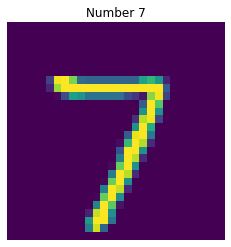

In [58]:
plt.imshow(features_train[25])
plt.axis("off")
plt.title("Number " + str(int(targets_train[25])))
plt.show() 

In [59]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, 
                     out_channels, 
                     kernel_size=3, 
                     stride=stride, 
                     padding=1, 
                     bias=False)

In [94]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out - self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample:
            residual = self.downsample(x)
        
        out += residual
        out = self.relu(out)
        
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(1, 16)
        self.bn =  nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[0], 2)
        self.layer3 = self.make_layer(block, 64, layers[1], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    
    def make_layer(self, block, out_channels, blocks, stride=1):
            downsample = None
            
            if (stride != 1) or (self.in_channels != out_channels):
                downsample = nn.Sequential(
                    conv3x3(self.in_channels, out_channels, stride=stride),
                    nn.BatchNorm2d(out_channels))
                
            layers = []
            layers.append(block(self.in_channels, out_channels, stride, downsample))
            self.in_channels = out_channels
            
            for i in range(1, blocks):
                layers.append(block(out_channels, out_channels))
            return nn.Sequential(*layers)
        
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out

In [96]:
net_args = {
    "block": ResidualBlock,
    "layers": [2,2,2,2]
}

model = ResNet(**net_args)

In [97]:
error = nn.CrossEntropyLoss()

In [98]:
learning_rate = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [99]:
loss_list = []
iteration_list = []
accuracy_list = []
count = 0

In [111]:
train_loader.batch_size

100

In [112]:
train_loader.dataset

In [113]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        train = Variable(images.resize_(batch_size, 1, 32, 32))
        labels = Variable(labels)
        
        optimizer.zero_grad()
        outputs = model(train)
        loss = error(outputs, labels)
        loss.backward()
        optimizer.step()
        
        count += 1
        
        if count % 250 == 0:
            correct = 0
            total = 0
            
            for images, labels in test_loader:
                images = Variable(images.resize_(batch_size, 1, 32, 32))
                outputs = model(images)
                
                predicted = torch.max(outputs.data, 1)[1]
                
                total += labels.size(0)
                correct += (predicted == labels).sum()

            accuracy = 100 * correct/float(total)
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
            print("Iteration: {}  Loss: {}  Accuracy: {} %".format(count, loss.data.item(), accuracy))
        

Iteration: 2250  Loss: 2.2994604110717773  Accuracy: 9.666666984558105 %
Iteration: 2500  Loss: 2.3086862564086914  Accuracy: 9.783333778381348 %
Iteration: 2750  Loss: 2.2945075035095215  Accuracy: 9.800000190734863 %
Iteration: 3000  Loss: 2.302509069442749  Accuracy: 10.824999809265137 %
Iteration: 3250  Loss: 2.3074557781219482  Accuracy: 10.158333778381348 %
Iteration: 3500  Loss: 2.30133056640625  Accuracy: 10.158333778381348 %
Iteration: 3750  Loss: 2.3018431663513184  Accuracy: 11.016666412353516 %
Iteration: 4000  Loss: 2.306149482727051  Accuracy: 11.016666412353516 %
Iteration: 4250  Loss: 2.3027260303497314  Accuracy: 10.824999809265137 %
Iteration: 4500  Loss: 2.3074378967285156  Accuracy: 11.016666412353516 %
Iteration: 4750  Loss: 2.296319007873535  Accuracy: 11.016666412353516 %
Iteration: 5000  Loss: 2.311678886413574  Accuracy: 10.158333778381348 %
Iteration: 5250  Loss: 2.293056011199951  Accuracy: 9.791666984558105 %
Iteration: 5500  Loss: 2.302060127258301  Accurac

KeyboardInterrupt: 

```
Iteration: 2250  Loss: 2.2994604110717773  Accuracy: 9.666666984558105 %
Iteration: 2500  Loss: 2.3086862564086914  Accuracy: 9.783333778381348 %
Iteration: 2750  Loss: 2.2945075035095215  Accuracy: 9.800000190734863 %
Iteration: 3000  Loss: 2.302509069442749  Accuracy: 10.824999809265137 %
Iteration: 3250  Loss: 2.3074557781219482  Accuracy: 10.158333778381348 %
Iteration: 3500  Loss: 2.30133056640625  Accuracy: 10.158333778381348 %
Iteration: 3750  Loss: 2.3018431663513184  Accuracy: 11.016666412353516 %
Iteration: 4000  Loss: 2.306149482727051  Accuracy: 11.016666412353516 %
Iteration: 4250  Loss: 2.3027260303497314  Accuracy: 10.824999809265137 %
Iteration: 4500  Loss: 2.3074378967285156  Accuracy: 11.016666412353516 %
Iteration: 4750  Loss: 2.296319007873535  Accuracy: 11.016666412353516 %
Iteration: 5000  Loss: 2.311678886413574  Accuracy: 10.158333778381348 %
Iteration: 5250  Loss: 2.293056011199951  Accuracy: 9.791666984558105 %
Iteration: 5500  Loss: 2.302060127258301  Accuracy: 10.824999809265137 %
Iteration: 5750  Loss: 2.307410955429077  Accuracy: 11.016666412353516 %
Iteration: 6000  Loss: 2.304231643676758  Accuracy: 9.791666984558105 %
Iteration: 6250  Loss: 2.318359613418579  Accuracy: 11.016666412353516 %
Iteration: 6500  Loss: 2.314941167831421  Accuracy: 9.800000190734863 %
Iteration: 6750  Loss: 2.2943100929260254  Accuracy: 11.016666412353516 %
Iteration: 7000  Loss: 2.282406806945801  Accuracy: 9.666666984558105 %
Iteration: 7250  Loss: 2.2960901260375977  Accuracy: 10.824999809265137 %
Iteration: 7500  Loss: 2.3232717514038086  Accuracy: 11.016666412353516 %
Iteration: 7750  Loss: 2.2987711429595947  Accuracy: 9.666666984558105 %
Iteration: 8000  Loss: 2.295541286468506  Accuracy: 9.666666984558105 %
Iteration: 8250  Loss: 2.3052279949188232  Accuracy: 11.016666412353516 %
```